In [216]:
import tsplib95
import numpy as np
import math
import random
import matplotlib.pyplot as plt

# 0. Wczytywanie danych

In [217]:
problemA = tsplib95.load("kroA100.tsp")
problemA = problemA.as_keyword_dict()

In [218]:
problemB = tsplib95.load("kroB100.tsp")
problemB = problemB.as_keyword_dict()

In [219]:
def create_distance_matrix(data):
    dict_length = len(data['NODE_COORD_SECTION'])
    distance_matrix = np.zeros((dict_length, dict_length), dtype=int)
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix[i])):
            x1 = data['NODE_COORD_SECTION'][i+1]
            x2 = data['NODE_COORD_SECTION'][j+1]
            d = math.floor(math.sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2) + 0.5)
            distance_matrix[i][j] = d
    return distance_matrix

In [220]:
distance_matrix_A = create_distance_matrix(problemA)
distance_matrix_B = create_distance_matrix(problemB)
startingPoints = dict()

# 1.Algorytmy

### Wybór punktów początkowych

In [221]:
def selectStartingPoints(id):
    if id == 'A':
        max_id = max_id = len(distance_matrix_A) - 1 
    else:
        max_id = max_id = len(distance_matrix_B) - 1 
    p1 = random.randint(0, max_id)
    p2 = random.randint(0, max_id)
    while p2 == p1:
        p2 = random.randint(0, max_id)
    return p1, p2

In [222]:
def selectP(experimentId):
    p1 = 0
    p2 = 0
    while True:
        p1, p2 = selectStartingPoints(experimentId)
        sId1 = str(p1)+","+str(p2)
        sId2 = str(p2)+","+str(p1)
        if sId1 not in startingPoints and sId2 not in startingPoints:
            startingPoints[sId1] = 1
            break
    return p1, p2

## 1.1 Algorytm zachłanny (greedy) inspirowany metodą najbliższego sąsiada (nearest neighbor)

In [223]:
def greedy_nearest_neighbor(experimentId, p1, p2):
    
    matrix_length = 0
    d_matrix = []
    if experimentId == 'A':
        matrix_length = len(distance_matrix_A) 
        d_matrix = distance_matrix_A
    else:
        matrix_length = len(distance_matrix_B)  
        d_matrix = distance_matrix_B
    selected = dict()
    selected[p1] = 1
    selected[p2] = 1
    result = [[p1],[p2]]
    resultVal = [[0],[0]]

    cycleId = 0
    while len(selected) < matrix_length:
        newDist = np.inf
        newArr = []
        newItem = np.inf
        for i in range(matrix_length):
            if i not in selected:
                for j in range(len(result[cycleId])+1):
                    new = result[cycleId][:j]
                    new.append(i)
                    new += result[cycleId][j:]
                    dist = 0
                    for k in range(1, len(new)):
                        dist += d_matrix[new[k-1]][new[k]]
                    if dist < newDist:
                        newDist = dist
                        newArr = new
                        newItem = i
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        if cycleId == 0:
            cycleId = 1
        else:
            cycleId = 0
    result[0].append(result[0][0])
    result[1].append(result[1][0])
    resultVal[0] += d_matrix[result[0][len(result[0]) - 1]][result[0][0]]
    resultVal[1] += d_matrix[result[1][len(result[1]) - 1]][result[1][0]]
    return result, resultVal

## 1.2 Algorytm zachłanny (greedy) inspirowany metodą rozbudowy cyklu (cycle greedy)

In [224]:
def find_first_cycle(experimentId, p, matrix_length, selected):
    
    d_matrix = []
    if experimentId == 'A':
        d_matrix = distance_matrix_A 
    else:
        d_matrix = distance_matrix_B
    minV = np.inf
    minId = p
    for i in range(matrix_length):
        if i not in selected:
            if d_matrix[p][i] < minV:
                minV = d_matrix[p][i]
                minId = i
    return minV, minId

In [225]:
def cycle_greedy(experimentId, p1, p2):
    
    matrix_length = 0
    d_matrix = []
    if experimentId == 'A':
        matrix_length = len(distance_matrix_A) 
        d_matrix = distance_matrix_A
    else:
        matrix_length = len(distance_matrix_B)  
        d_matrix = distance_matrix_B  
    selected = dict()
    selected[p1] = 1
    selected[p2] = 1
    result = [[p1],[p2]]
    resultVal = [[0],[0]]

    minV, minId = find_first_cycle(experimentId, p1, matrix_length, selected)
    selected[minId] = 1
    result[0].append(minId)
    resultVal[0] = minV

    minV, minId = find_first_cycle(experimentId, p2, matrix_length, selected)
    selected[minId] = 1
    result[1].append(minId)
    resultVal[1] = minV

    cycleId = 0

    while len(selected) < matrix_length:
        newDist = np.inf
        newArr = []
        newItem = np.inf
        for i in range(matrix_length):
            if i not in selected:
                for j in range(len(result[cycleId])+1):
                    new = result[cycleId][:j]
                    new.append(i)
                    new += result[cycleId][j:]
                    dist = 0
                    for k in range(1, len(new)):
                        dist += d_matrix[new[k-1]][new[k]]
                    dist += d_matrix[new[len(new) - 1]][new[0]]
                    if dist < newDist:
                        newDist = dist
                        newArr = new
                        newItem = i
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        if cycleId == 0:
            cycleId = 1
        else:
            cycleId = 0
    result[0].append(result[0][0])
    result[1].append(result[1][0])
    return result, resultVal

## 1.3 Algorytm 2-regret heuristics inspirowany metodą rozbudowy cyklu 

In [226]:
def regret_heuristics(experimentId, p1, p2):
    
    matrix_length = 0
    d_matrix = []
    if experimentId == 'A':
        matrix_length = len(distance_matrix_A) 
        d_matrix = distance_matrix_A
    else:
        matrix_length = len(distance_matrix_B)  
        d_matrix = distance_matrix_B    
    selected = dict()
    selected[p1] = 1
    selected[p2] = 1
    result = [[p1],[p2]]
    resultVal = [[0],[0]]

    minV, minId = find_first_cycle(experimentId, p1, matrix_length, selected)
    selected[minId] = 1
    result[0].append(minId)
    resultVal[0] = minV

    minV, minId = find_first_cycle(experimentId, p2, matrix_length, selected)
    selected[minId] = 1
    result[1].append(minId)
    resultVal[1] = minV

    cycleId = 0

    while len(selected) < matrix_length:
        newRegret = -1
        newArr = []
        newItem = np.inf
        newDist = 0
        for i in range(matrix_length):
            if i not in selected:
                costs = []
                for j in range(len(result[cycleId])+1):
                    dist = 0
                    new = result[cycleId][:j]
                    new.append(i)
                    new += result[cycleId][j:]
                    for k in range(1, len(new)):
                        dist += d_matrix[new[k-1]][new[k]]
                    dist += d_matrix[new[len(new) - 1]][new[0]]
                    cost = dist - resultVal[cycleId]
                    costs.append(cost)
                newPos = costs.index(min(costs))
                newSorted = sorted(costs)
                regret = newSorted[1] - newSorted[0]
                if regret > newRegret:
                    newRegret = regret
                    newArr = result[cycleId][:newPos]
                    newArr.append(i)
                    newArr += result[cycleId][newPos:]
                    newItem = i
                    for k in range(1, len(newArr)):
                        newDist += d_matrix[newArr[k-1]][newArr[k]]
                    newDist += d_matrix[newArr[len(new) - 1]][newArr[0]]
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        if cycleId == 0:
            cycleId = 1
        else:
            cycleId = 0
    result[0].append(result[0][0])
    result[1].append(result[1][0])
    return result, resultVal

## 1.4 Heurystyka z 2-żalem ważonym z podstawowym kryterium wyboru

In [227]:
def weighted_criterion(experimentId, p1, p2):
    
    matrix_length = 0
    d_matrix = []
    if experimentId == 'A':
        matrix_length = len(distance_matrix_A) 
        d_matrix = distance_matrix_A
    else:
        matrix_length = len(distance_matrix_B)  
        d_matrix = distance_matrix_B    
    selected = dict()
    selected[p1] = 1
    selected[p2] = 1
    result = [[p1],[p2]]
    resultVal = [[0],[0]]

    minV, minId = find_first_cycle(experimentId, p1, matrix_length, selected)
    selected[minId] = 1
    result[0].append(minId)
    resultVal[0] = minV

    minV, minId = find_first_cycle(experimentId, p2, matrix_length, selected)
    selected[minId] = 1
    result[1].append(minId)
    resultVal[1] = minV

    cycleId = 0

    while len(selected) < matrix_length:
        newCriterion = -1
        newArr = []
        newItem = np.inf
        newDist = 0
        for i in range(matrix_length):
            if i not in selected:
                costs = []
                for j in range(len(result[cycleId])+1):
                    dist = 0
                    new = result[cycleId][:j]
                    new.append(i)
                    new += result[cycleId][j:]
                    for k in range(1, len(new)):
                        dist += d_matrix[new[k-1]][new[k]]
                    dist += d_matrix[new[len(new) - 1]][new[0]]
                    cost = dist - resultVal[cycleId]
                    costs.append(cost)
                newPos = costs.index(min(costs))
                newSorted = sorted(costs)
                regret = newSorted[1] - newSorted[0]
                nArr = result[cycleId][:newPos]
                nArr.append(i)
                nArr += result[cycleId][newPos:]
                nDist = 0 
                for k in range(1, len(nArr)):
                    nDist += d_matrix[nArr[k-1]][nArr[k]]
                nDist += d_matrix[nArr[len(nArr) - 1]][nArr[0]]
                c = regret / nDist    
                if c > newCriterion:
                    newRegret = regret
                    newArr = nArr
                    newItem = i
                    newDist = nDist
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        if cycleId == 0:
            cycleId = 1
        else:
            cycleId = 0
    result[0].append(result[0][0])
    result[1].append(result[1][0])
    return result, resultVal

# 2. Eksperyment obliczeniowy

In [228]:
resultA1 = []
resultValA1 = []
resultA2 = []
resultValA2 = []
resultA3 = []
resultValA3 = []
resultA4 = []
resultValA4 = []

In [229]:
def runExperiment(experimentId):
    itersNumber = 100
    
    for i in range(itersNumber):
        
        p1, p2 = selectP(experimentId)
        
        rA1, rValA1 = greedy_nearest_neighbor(experimentId, p1, p2)
        resultA1.append(rA1)
        resultValA1.append(rValA1)
        
        rA2, rValA2 = cycle_greedy(experimentId, p1, p2)
        resultA2.append(rA2)
        resultValA2.append(rValA2)
        
        rA3, rValA3 = regret_heuristics(experimentId, p1, p2)
        resultA3.append(rA3)
        resultValA3.append(rValA3)
    
        rA4, rValA4 = weighted_criterion(experimentId, p1, p2)
        resultA4.append(rA4)
        resultValA4.append(rValA4)
     

In [230]:
startingPoints = dict()
runExperiment('A')

# 3. Wyniki

In [231]:
def print_plot(data, points, title, fileName):
    f = plt.figure()
    plt.plot(data[:, 0], data[:, 1], "o", linewidth=0, alpha=0.4)
    plt.plot(data[points[0], 0], data[points[0], 1], "o", color='tab:blue',  linewidth=0, alpha=0.6)
    plt.plot(data[points[0], 0], data[points[0], 1], "--", color="tab:cyan", linewidth=1, alpha=2)
    plt.plot(data[points[1], 0], data[points[1], 1], "o", color='tab:red',  linewidth=0, alpha=0.6)
    plt.plot(data[points[1], 0], data[points[1], 1], "--", color="tab:orange", linewidth=1, alpha=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(False)
    
    plt.show()
    f.savefig(fileName, bbox_inches='tight')

In [232]:
problemA['NODE_COORD_SECTION']
dataA = []
for i in range(1, len(problemA['NODE_COORD_SECTION'])+1):
    dataA.append(problemA['NODE_COORD_SECTION'][i])
dataArrA = np.array(dataA)

In [233]:
problemB['NODE_COORD_SECTION']
dataB = []
for i in range(1, len(problemB['NODE_COORD_SECTION'])+1):
    dataB.append(problemB['NODE_COORD_SECTION'][i])
dataArrB = np.array(dataB)

## 3.1 Instancja kroA100

20660
[[81, 94, 12, 75, 32, 36, 4, 51, 77, 95, 29, 38, 84, 67, 72, 49, 43, 1, 53, 39, 63, 68, 80, 24, 60, 50, 86, 8, 6, 56, 19, 11, 45, 42, 2, 40, 70, 99, 47, 13, 28, 33, 82, 54, 26, 85, 34, 61, 59, 76, 81], [89, 48, 5, 62, 0, 91, 7, 41, 88, 30, 79, 55, 96, 74, 18, 3, 64, 25, 65, 69, 93, 21, 15, 87, 52, 78, 17, 23, 37, 98, 35, 83, 9, 71, 20, 73, 58, 16, 14, 10, 31, 44, 90, 22, 97, 46, 92, 27, 66, 57, 89]]
27618
24235.0


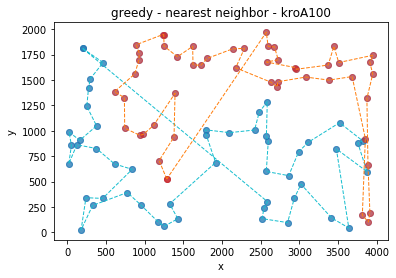

In [234]:
minA1 = np.inf
maxA1 = 0
meanA1 = 0
minA1Res = []
for i in range (len(resultValA1)):
    sumItem = resultValA1[i][0] + resultValA1[i][1]
    if sumItem < minA1:
        minA1 = sumItem
        minA1res = resultA1[i]
    if sumItem > maxA1:
        maxA1 = sumItem
    meanA1 += sumItem
meanA1 = meanA1/100
print(minA1)
print(minA1res)
print(maxA1)
print(meanA1)
print_plot(dataArrA, resultA1[0], "greedy - nearest neighbor - kroA100", 'algorithm1A.png')

25841
[[26, 34, 85, 61, 59, 22, 44, 14, 16, 58, 73, 20, 71, 35, 98, 37, 23, 17, 93, 21, 69, 15, 87, 78, 83, 9, 10, 31, 46, 90, 97, 76, 19, 11, 56, 86, 6, 8, 54, 82, 33, 28, 13, 47, 99, 70, 40, 2, 42, 45, 26], [95, 29, 84, 67, 72, 80, 24, 50, 60, 57, 92, 27, 0, 62, 5, 48, 89, 52, 18, 65, 25, 64, 3, 96, 55, 74, 91, 7, 41, 79, 30, 88, 66, 68, 63, 39, 53, 1, 43, 49, 81, 94, 12, 75, 32, 38, 36, 4, 51, 77, 95]]
31000
28763.93


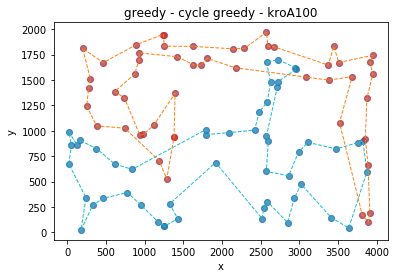

In [235]:
minA2 = np.inf
maxA2 = 0
meanA2 = 0
minA2Res = []
for i in range (len(resultValA2)):
    sumItem = resultValA2[i][0] + resultValA2[i][1]
    if sumItem < minA2:
        minA2 = sumItem
        minA2res = resultA2[i]
    if sumItem > maxA2:
        maxA2 = sumItem
    meanA2 += sumItem
meanA2 = meanA2/100
print(minA2)
print(minA2res)
print(maxA2)
print(meanA2)
print_plot(dataArrA, resultA2[0], "greedy - cycle greedy - kroA100", 'algorithm2A.png')

30134
[[0, 62, 5, 48, 89, 18, 74, 91, 41, 88, 30, 79, 55, 96, 3, 64, 25, 65, 69, 21, 93, 15, 87, 52, 78, 17, 23, 83, 9, 71, 73, 16, 46, 90, 97, 59, 26, 6, 54, 45, 2, 13, 47, 77, 4, 32, 49, 72, 63, 39, 0], [7, 66, 27, 92, 57, 60, 24, 80, 68, 53, 1, 43, 81, 94, 75, 12, 36, 51, 95, 38, 67, 84, 29, 99, 70, 40, 42, 28, 33, 82, 8, 86, 50, 56, 19, 11, 85, 34, 61, 76, 22, 44, 31, 10, 14, 58, 20, 35, 98, 37, 7]]
54685
37732.02


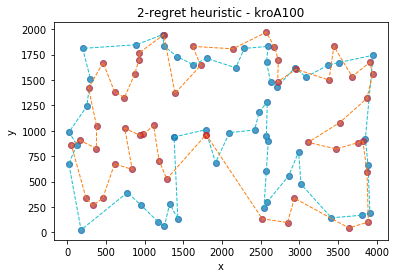

In [236]:
minA3 = np.inf
maxA3 = 0
meanA3 = 0
minA3Res = []
for i in range (len(resultValA3)):
    sumItem = resultValA3[i][0] + resultValA3[i][1]
    if sumItem < minA3:
        minA3 = sumItem
        minA3res = resultA3[i]
    if sumItem > maxA3:
        maxA3 = sumItem
    meanA3 += sumItem
meanA3 = meanA3/100
print(minA3)
print(minA3res)
print(maxA3)
print(meanA3)
print_plot(dataArrA, resultA3[0], "2-regret heuristic - kroA100", 'algorithm3A.png')

31591
[[76, 97, 44, 31, 46, 58, 9, 62, 5, 48, 89, 78, 23, 17, 93, 21, 15, 87, 52, 25, 64, 3, 74, 91, 7, 27, 66, 50, 80, 68, 1, 72, 84, 38, 36, 95, 29, 13, 99, 70, 40, 42, 33, 82, 54, 11, 56, 19, 61, 59, 76], [26, 86, 8, 6, 45, 28, 2, 47, 77, 51, 4, 32, 75, 12, 94, 81, 43, 49, 67, 63, 39, 53, 24, 60, 57, 92, 0, 41, 88, 30, 79, 55, 96, 18, 65, 69, 83, 37, 98, 35, 71, 20, 73, 16, 14, 10, 90, 22, 34, 85, 26]]
38213
34536.62


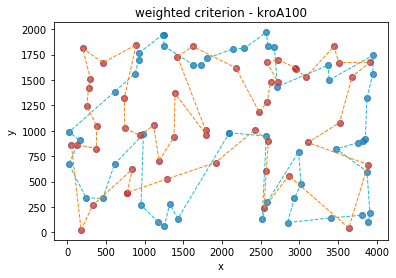

In [237]:
minA4 = np.inf
maxA4 = 0
meanA4 = 0
minA4Res = []
for i in range (len(resultValA4)):
    sumItem = resultValA4[i][0] + resultValA4[i][1]
    if sumItem < minA4:
        minA4 = sumItem
        minA4res = resultA4[i]
    if sumItem > maxA4:
        maxA4 = sumItem
    meanA4 += sumItem
meanA4 = meanA4/100
print(minA4)
print(minA4res)
print(maxA4)
print(meanA4)
print_plot(dataArrA, resultA4[0], "weighted criterion - kroA100", 'algorithm4A.png')

## 3.2 Instancja kroB100

In [238]:
resultA1 = []
resultValA1 = []
resultA2 = []
resultValA2 = []
resultA3 = []
resultValA3 = []
resultA4 = []
resultValA4 = []

In [239]:
startingPoints = dict()
runExperiment('B')

22683
[[43, 40, 16, 35, 44, 91, 18, 95, 17, 23, 76, 49, 54, 22, 21, 87, 71, 36, 46, 64, 78, 80, 55, 99, 25, 74, 79, 29, 68, 61, 4, 66, 39, 38, 69, 52, 72, 84, 92, 10, 2, 27, 90, 96, 75, 98, 7, 28, 31, 58, 43], [34, 60, 70, 11, 97, 94, 0, 89, 20, 9, 67, 85, 48, 19, 37, 8, 45, 24, 26, 93, 56, 33, 6, 83, 57, 53, 51, 42, 88, 86, 59, 73, 65, 3, 82, 5, 14, 32, 81, 63, 13, 41, 1, 47, 50, 30, 62, 12, 77, 15, 34]]
29713
25017.44


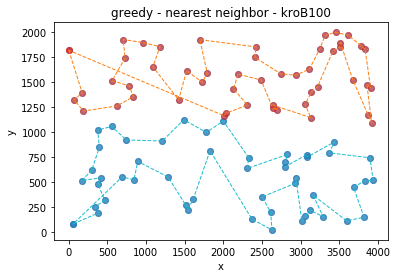

In [240]:
minA1 = np.inf
maxA1 = 0
meanA1 = 0
minA1Res = []
for i in range (len(resultValA1)):
    sumItem = resultValA1[i][0] + resultValA1[i][1]
    if sumItem < minA1:
        minA1 = sumItem
        minA1res = resultA1[i]
    if sumItem > maxA1:
        maxA1 = sumItem
    meanA1 += sumItem
meanA1 = meanA1/100
print(minA1)
print(minA1res)
print(maxA1)
print(meanA1)
print_plot(dataArrB, resultA1[0], "greedy - nearest neighbor - kroB100", 'algorithm1B.png')

25577
[[89, 20, 37, 19, 79, 74, 29, 71, 36, 64, 46, 78, 80, 55, 99, 25, 61, 4, 66, 69, 52, 38, 39, 68, 85, 48, 67, 9, 94, 28, 7, 98, 2, 84, 72, 10, 92, 27, 90, 96, 75, 58, 31, 97, 11, 70, 8, 24, 45, 0, 89], [26, 33, 57, 53, 51, 42, 88, 86, 82, 13, 63, 41, 1, 15, 49, 54, 21, 22, 87, 76, 23, 17, 95, 18, 43, 91, 44, 35, 40, 16, 77, 12, 62, 30, 47, 50, 81, 32, 14, 5, 3, 65, 59, 73, 83, 6, 56, 93, 34, 60, 26]]
30965
28476.61


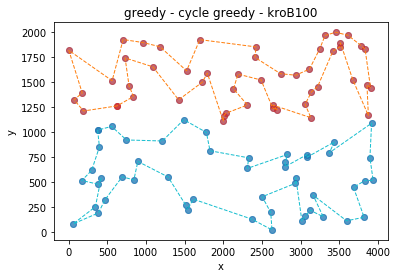

In [241]:
minA2 = np.inf
maxA2 = 0
meanA2 = 0
minA2Res = []
for i in range (len(resultValA2)):
    sumItem = resultValA2[i][0] + resultValA2[i][1]
    if sumItem < minA2:
        minA2 = sumItem
        minA2res = resultA2[i]
    if sumItem > maxA2:
        maxA2 = sumItem
    meanA2 += sumItem
meanA2 = meanA2/100
print(minA2)
print(minA2res)
print(maxA2)
print(meanA2)
print_plot(dataArrB, resultA2[0], "greedy - cycle greedy - kroB100", 'algorithm2B.png')

30145
[[59, 56, 93, 34, 60, 26, 70, 0, 94, 31, 58, 75, 28, 7, 98, 96, 90, 27, 2, 10, 92, 84, 72, 9, 67, 52, 69, 38, 39, 66, 4, 61, 68, 48, 85, 37, 19, 79, 29, 74, 99, 55, 80, 78, 64, 46, 22, 18, 43, 91, 59], [73, 42, 88, 86, 65, 3, 82, 5, 14, 32, 63, 13, 15, 1, 41, 81, 47, 50, 30, 62, 12, 77, 16, 40, 44, 35, 95, 17, 23, 76, 49, 54, 21, 87, 25, 36, 71, 53, 51, 57, 83, 6, 33, 8, 24, 45, 20, 89, 11, 97, 73]]
53130
37451.78


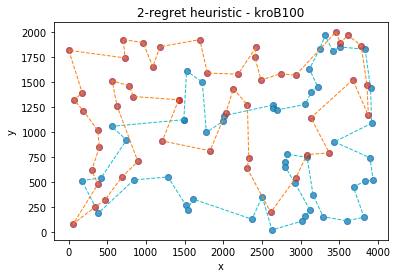

In [242]:
minA3 = np.inf
maxA3 = 0
meanA3 = 0
minA3Res = []
for i in range (len(resultValA3)):
    sumItem = resultValA3[i][0] + resultValA3[i][1]
    if sumItem < minA3:
        minA3 = sumItem
        minA3res = resultA3[i]
    if sumItem > maxA3:
        maxA3 = sumItem
    meanA3 += sumItem
meanA3 = meanA3/100
print(minA3)
print(minA3res)
print(maxA3)
print(meanA3)
print_plot(dataArrB, resultA3[0], "2-regret heuristic - kroB100", 'algorithm3B.png')

32903
[[7, 28, 97, 11, 34, 93, 56, 59, 73, 65, 86, 42, 88, 82, 3, 5, 13, 63, 32, 50, 30, 1, 15, 76, 17, 44, 40, 95, 91, 23, 54, 21, 71, 36, 46, 78, 80, 99, 25, 61, 19, 48, 67, 9, 38, 69, 52, 84, 27, 90, 7], [96, 98, 2, 10, 92, 72, 66, 4, 39, 85, 68, 55, 74, 29, 37, 79, 64, 87, 22, 18, 43, 35, 16, 77, 12, 62, 47, 14, 81, 41, 49, 51, 53, 57, 83, 6, 33, 26, 60, 70, 8, 24, 45, 20, 89, 0, 94, 31, 58, 75, 96]]
37468
34965.1


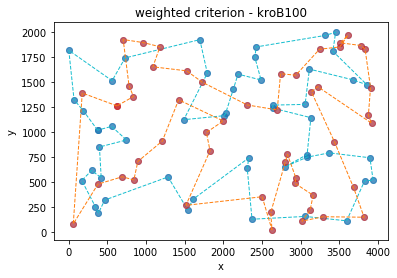

In [243]:
minA4 = np.inf
maxA4 = 0
meanA4 = 0
minA4Res = []
for i in range (len(resultValA4)):
    sumItem = resultValA4[i][0] + resultValA4[i][1]
    if sumItem < minA4:
        minA4 = sumItem
        minA4res = resultA4[i]
    if sumItem > maxA4:
        maxA4 = sumItem
    meanA4 += sumItem
meanA4 = meanA4/100
print(minA4)
print(minA4res)
print(maxA4)
print(meanA4)
print_plot(dataArrB, resultA4[0], "weighted criterion - kroB100", 'algorithm4B.png')